In [1]:
import numpy as np
import torch
import cv2
import h5py
from matplotlib import pyplot as plt
import src.models as models

In [2]:
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)

## Load core

In [3]:
corename = 's33_c070'
mask_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/mask/{corename}.png'
mask = cv2.imread(mask_filepath) / 255.0

annot_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/annotation/{corename}.png'
annot = cv2.imread(annot_filepath)[:,:,::-1] / 255.0

core_filepath = rf'D:/datasets/pcuk2023_ftir_whole_core/spectral/{corename}.h5'
f = h5py.File(core_filepath)
datacube = f['spectra'][:] * mask[:,:,0:1]
f.close()

print(f"Loaded core with shape: {datacube.shape} and mask with shape: {mask.shape} and annotations with shape {annot.shape}")

Loaded core with shape: (256, 256, 965) and mask with shape: (256, 256, 3) and annotations with shape (256, 256, 3)


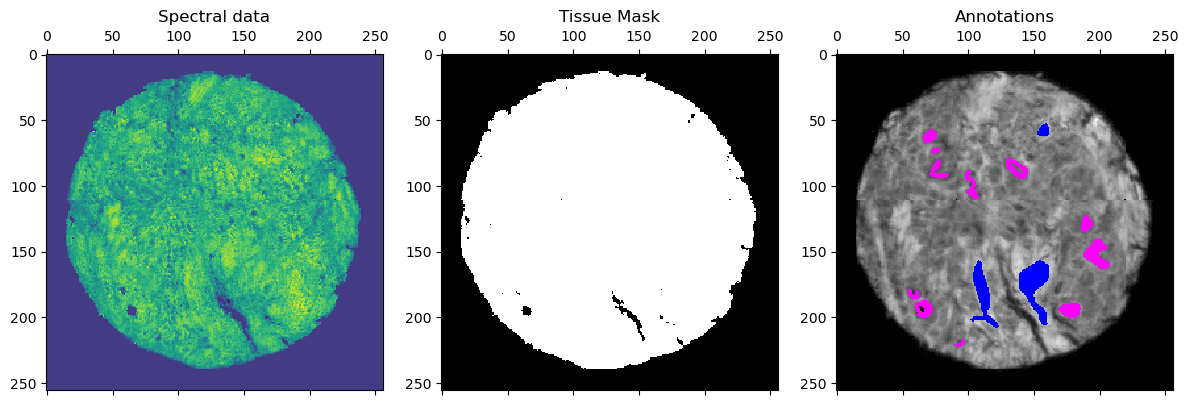

In [4]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].matshow(datacube[:,:,300]); ax[0].set_title("Spectral data")
ax[1].matshow(mask); ax[1].set_title("Tissue Mask")
ax[2].matshow(annot); ax[2].set_title("Annotations")
fig.tight_layout()

## Load model

In [5]:
model_use = 'patch_25px'

if model_use == 'mlp':
    model = models.MLP(965, 64, n_classes, 'linear', dropout_p=0.5)
    patch_size = 1
    model.load_state_dict(torch.load(r'./model_weights/mlp_linear_weights_55.pt',weights_only=True))
elif model_use == 'patch_3px':
    model = models.patch3_cnn(965, 64, n_classes, 'linear', dropout_p=0.5)
    patch_size = 3
    model.load_state_dict(torch.load(r'./model_weights/patch_3px_linear_weights_55.pt',weights_only=True))
elif model_use == 'patch_25px':
    model = models.patch25_cnn(965, 64, n_classes, 'linear', dropout_p=0.5)
    patch_size = 25
    model.load_state_dict(torch.load(r'./model_weights/patch_25px_linear_weights_55.pt',weights_only=True))
elif model_use == 'patch_101px':
    model = models.patch101_cnn(965, 64, n_classes, 'linear', dropout_p=0.5)
    patch_size = 101
    model.load_state_dict(torch.load(r'./model_weights/patch_101px_linear_weights_55.pt',weights_only=True))
elif model_use == 'patch_multiscale':
    model = models.patch_multiscale(965, 64, n_classes, 'linear', dropout_p=0.5)
    patch_size = 101
    model.load_state_dict(torch.load(r'./model_weights/patch_multiscale_linear_weights_55.pt',weights_only=True))
elif model_use == 'patch_transformer':
    patch_size = 25
    model = models.patch25_transformer(965, 64, n_classes, 256, 'linear')
    model.load_state_dict(torch.load(r'./model_weights/patch_transformer_linear_weights_55.pt',weights_only=True))
model.eval()

patch25_cnn(
  (input_processing): LinearReduction(
    (input_norm): BatchNorm2d(965, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (projection): Conv2d(965, 64, kernel_size=(1, 1), stride=(1, 1))
    (projection_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1

## Predict

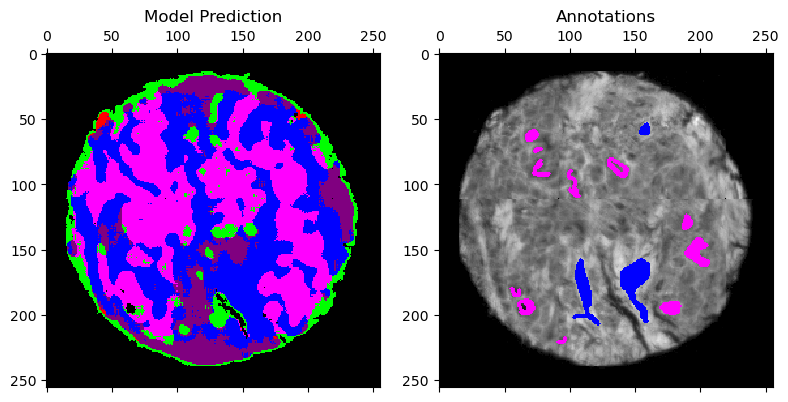

In [6]:
datacube_as_windows = torch.nn.functional.pad(
    torch.from_numpy(datacube).float(), # convert core numpy to torch tensor
    (0,0,patch_size//2,patch_size//2,patch_size//2,patch_size//2) # pad tensor on spatial sides so every pixel has a window
).unfold(0, patch_size, 1).unfold(1,patch_size,1) # unfold tensor into windows

# run each pixel as a patch through the network
# warning!! this may take a *long* time for the larger patch sizes
out = torch.zeros((256,256,6))
with torch.no_grad():
    for row_idx in range(0,256):
        for col_idx in range(0,256,32):
            out[row_idx,col_idx:col_idx+32] = model(datacube_as_windows[row_idx,col_idx:col_idx+32])
out = out.permute(2,0,1)
pred = annotation_class_colors[out.squeeze().argmax(0)] * mask / 255.0

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].matshow(pred); ax[0].set_title("Model Prediction")
ax[1].matshow(annot); ax[1].set_title("Annotations")
fig.tight_layout()

## Save output

In [7]:
cv2.imwrite(f'./pred_images/{model_use}_{corename}.png', np.rint(pred[..., ::-1] * 255.0))

True